Marcin Grzyb marcingrzyb@student.agh.edu.pl 
Paweł Gałka pawelgalka@student.agh.edu.pl

The problem we are trying to solve here is to classify grayscale images of handwritten digits (28 pixels by 28 pixels), into their 10 
categories (0 to 9). The dataset we will use is the MNIST dataset, a classic dataset in the machine learning community, which has been 
around for almost as long as the field itself and has been very intensively studied. It's a set of 60,000 training images, plus 10,000 test 
images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. You can think of "solving" MNIST 
as the "Hello World" of deep learning -- it's what you do to verify that your algorithms are working as expected. As you become a machine 
learning practitioner, you will see MNIST come up over and over again, in scientific papers, blog posts, and so on.

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


In [0]:
## [deskew]
SZ=28
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img
## [deskew]


In [0]:
def showOpencvImage(image, isGray=False):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap = 'gray')
    plt.show()

In [0]:
def openCVHOG(im):
    winSize = (20,20)
    blockSize = (10,10)
    blockStride = (5,5)
    cellSize = (10,10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradients = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradients)
    descriptor = np.ravel(hog.compute(im))
    
    return descriptor

In [0]:
from skimage.feature import haar_like_feature
from skimage.transform import integral_image
def haarFeature(im):
  return haar_like_feature(integral_image(im),0,0,20,20,feature_type=['type-4'])


The **MNIST dataset comes pre-loaded in Keras**, in the form of a set of four Numpy arrays:

In [0]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [0]:
#reshaping raw data
train_images_raw = train_images.reshape((60000, 28 * 28))
train_images_raw = train_images_raw.astype('float32') / 255

test_images_raw = test_images.reshape((10000, 28 * 28))
test_images_raw = test_images_raw.astype('float32') / 255

train_images_raw=train_images_raw[0:1000,:]
test_images_raw=test_images_raw[0:400,:]

train_labels_raw=train_labels[0:1000]
test_labels_raw=test_labels[0:400]




Test klasyfikatora SVC z surowymi danymi na wejściu

In [37]:
import numpy
from sklearn.model_selection import cross_val_score
#kfold cross validation parameters selection
results=[]
for c in numpy.arange(15,20,1):
  for g in numpy.arange(0.1,2.1,0.5):
    results.append((cross_val_score(estimator = svm.SVC(C=c,gamma=g).fit(train_images_raw[0:400,:],train_labels_raw[0:400]), X = train_images_raw[0:400,:], y = train_labels_raw[0:400], cv = 5).mean(),c,g))


bestParams=max(results)
print("Parametry modelu ",bestParams[1:])

model = svm.SVC(C=bestParams[1],gamma=bestParams[2],class_weight='balanced')
model = model.fit(train_images_raw[400:1000,:],train_labels_raw[400:1000])


pred_labels = model.predict(test_images_raw)

mask = pred_labels==test_labels_raw
correct = np.count_nonzero(mask)
print("Procent skutecznych klasyfikacji: ", correct*100.0/pred_labels.size)

cm = confusion_matrix(test_labels_raw, pred_labels)
print(cm)
print(classification_report(test_labels_raw, pred_labels))



Parametry modelu  (19, 0.1)
Procent skutecznych klasyfikacji:  55.5
[[20  0  0  0  0  0  0 13  0  0]
 [ 0 56  0  0  0  0  0  1  0  0]
 [ 0  0 14  0  0  0  0 30  0  0]
 [ 0  0  1  2  0  6  0 26  0  0]
 [ 0  0  0  0 36  0  0  9  0  1]
 [ 0  0  0  0  1 22  0 19  0  0]
 [ 0  0  0  0  0  2 14 18  0  0]
 [ 0  0  0  0  0  0  0 41  0  0]
 [ 0  0  1  0  0  0  0 21  5  0]
 [ 0  0  0  0  4  0  0 25  0 12]]
              precision    recall  f1-score   support

           0       1.00      0.61      0.75        33
           1       1.00      0.98      0.99        57
           2       0.88      0.32      0.47        44
           3       1.00      0.06      0.11        35
           4       0.88      0.78      0.83        46
           5       0.73      0.52      0.61        42
           6       1.00      0.41      0.58        34
           7       0.20      1.00      0.34        41
           8       1.00      0.19      0.31        27
           9       0.92      0.29      0.44        41

    a

Test klasyfikatora RFC z surowymi danymi na wejściu

In [38]:
#raw data test rfc

import numpy
from sklearn.model_selection import cross_val_score
#kfold cross validation parameters selection
results=[]
for maxd in numpy.arange(5,15,5):
  for nestim in numpy.arange(60,120,20):
    for maxf in numpy.arange(15,45,15):#obszar poszukiwan parametrow ograniczony aby przyspieszyc wykonywanie sie skryptu, uwzgledniajac wartosci znalezione przy przesuzkiwaniu wiekszej kombinacji 
      results.append((cross_val_score(estimator = RandomForestClassifier(max_depth=maxd, n_estimators=nestim, max_features=maxf).fit(train_images_raw[0:400,:],train_labels_raw[0:400]), X = train_images_raw[0:400,:], y = train_labels_raw[0:400], cv = 5).mean(),maxd,nestim,maxf))

bestParams=max(results)
print("Parametry modelu ",bestParams[1:])

rfc =  RandomForestClassifier(max_depth=bestParams[1], n_estimators=bestParams[2], max_features=bestParams[3],class_weight='balanced')
rfc = rfc.fit(train_images_raw[400:1000,:],train_labels_raw[400:1000])

pred_labels = rfc.predict(test_images_raw)

mask = pred_labels==test_labels_raw
correct = np.count_nonzero(mask)
print("Procent skutecznych klasyfikacji: ", correct*100.0/pred_labels.size)

cm = confusion_matrix(test_labels_raw, pred_labels)
print(cm)
print(classification_report(test_labels_raw, pred_labels))


Parametry modelu  (10, 100, 30)
Procent skutecznych klasyfikacji:  84.5
[[32  0  0  0  0  0  0  1  0  0]
 [ 0 57  0  0  0  0  0  0  0  0]
 [ 0  0 34  2  0  0  2  5  1  0]
 [ 0  0  2 21  1  8  0  3  0  0]
 [ 0  0  0  1 39  1  2  0  0  3]
 [ 1  1  0  0  2 35  0  2  0  1]
 [ 1  0  3  0  2  1 25  0  2  0]
 [ 0  0  0  0  0  0  0 41  0  0]
 [ 0  0  1  0  1  2  0  0 22  1]
 [ 0  1  1  0  2  2  0  3  0 32]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        33
           1       0.97      1.00      0.98        57
           2       0.83      0.77      0.80        44
           3       0.88      0.60      0.71        35
           4       0.83      0.85      0.84        46
           5       0.71      0.83      0.77        42
           6       0.86      0.74      0.79        34
           7       0.75      1.00      0.85        41
           8       0.88      0.81      0.85        27
           9       0.86      0.78      0.82        41

 

Przygotowywanie danych z użyciem funkcji deskew

70000
70000


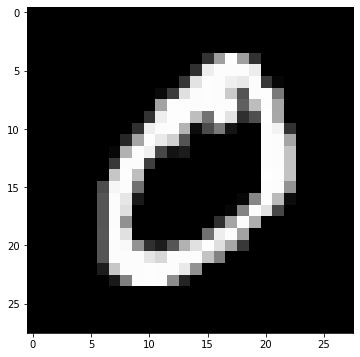

0


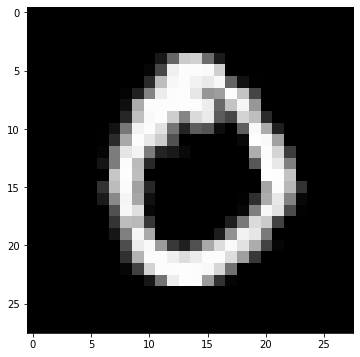

0


In [39]:
im_list = [train_images[i] for i in range(0,train_images.shape[0])] + [test_images[i] for i in range(0,test_images.shape[0])]
print(len(im_list))

im_list_labels=[train_labels[i] for i in range(0,train_labels.shape[0])] + [test_labels[i] for i in range(0,test_labels.shape[0])]
print(len(im_list_labels))

train_deskewed = [deskew(im) for im in im_list[0:train_images.shape[0]]]
test_deskewed = [deskew(im) for im in im_list[train_images.shape[0]:]]

train_deskewed = np.asarray(train_deskewed)
test_deskewed = np.asarray(test_deskewed)

#creating deskewed  dataset
im_list_deskewed = [train_deskewed[i] for i in range(0,train_deskewed.shape[0])] + [test_deskewed[i] for i in range(0,test_deskewed.shape[0])]
#

showOpencvImage(train_images[1])
print(train_labels[1])

showOpencvImage(train_deskewed[1])
print(train_labels[1])


Deskrptor HOG na danych nie wyprostowanych z użyciem funkcji deskew

In [40]:
hogdata = [openCVHOG(im) for im in im_list]
print(len(hogdata))
print(hogdata[0].shape)
imData = np.float32(hogdata).reshape(-1,81)
print(imData.shape)



70000
(81,)
(70000, 81)


Deskrptor HOG na danych wyprostowanych z użyciem funkcji deskew

In [41]:
hogdata2 = [openCVHOG(im) for im in im_list_deskewed]
print(len(hogdata2))
print(hogdata2[0].shape)
imData2 = np.float32(hogdata2).reshape(-1,81)
print(imData2.shape)

70000
(81,)
(70000, 81)


Deskrptor cech Haara na danych wyprostowanych z użyciem funkcji deskew

In [42]:
#using haar
haardata=[haarFeature(im) for im in im_list_deskewed[0:1400]]
print(haardata[0].shape)
imData3 = np.float32(haardata).reshape(-1,10000)
print(imData3.shape)

(10000,)
(1400, 10000)


Klasyfikator SVC na danych bez użycia funkcji deskew, deskryptor HOG

In [43]:

import numpy
from sklearn.model_selection import cross_val_score
#kfold cross validation parameters selection
results=[]
for c in numpy.arange(20,30,1):
  for g in numpy.arange(0.1,1.1,0.1):
    results.append((cross_val_score(estimator = svm.SVC(C=c,gamma=g).fit(imData[0:400,:],im_list_labels[0:400]), X = imData[0:400,:], y = im_list_labels[0:400], cv = 5).mean(),c,g))


bestParams=max(results)
print("Parametry modelu ",bestParams[1:])

model = svm.SVC(C=bestParams[1],gamma=bestParams[2],class_weight='balanced')
model = model.fit(imData[400:1000,:],im_list_labels[400:1000])

pred_labels = model.predict(imData[1000:1400,:])


mask = pred_labels==im_list_labels[1000:1400]
correct = np.count_nonzero(mask)
print("Procent skutecznych klasyfikacji: ", correct*100.0/pred_labels.size)

cm = confusion_matrix(im_list_labels[1000:1400], pred_labels)
print(cm)
print(classification_report(im_list_labels[1000:1400], pred_labels))

Parametry modelu  (29, 0.6)
Procent skutecznych klasyfikacji:  89.25
[[31  0  0  0  0  0  1  0  1  2]
 [ 0 41  3  0  0  0  1  0  0  0]
 [ 0  0 33  1  0  1  0  2  0  1]
 [ 0  1  5 24  1  2  0  2  0  3]
 [ 0  0  0  0 42  0  0  0  1  0]
 [ 0  0  1  0  0 27  0  0  2  2]
 [ 0  0  0  0  2  0 35  0  0  0]
 [ 1  0  1  1  0  1  0 46  0  0]
 [ 0  0  0  0  0  1  0  0 36  1]
 [ 0  0  0  1  0  0  0  1  0 42]]
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        35
           1       0.98      0.91      0.94        45
           2       0.77      0.87      0.81        38
           3       0.89      0.63      0.74        38
           4       0.93      0.98      0.95        43
           5       0.84      0.84      0.84        32
           6       0.95      0.95      0.95        37
           7       0.90      0.92      0.91        50
           8       0.90      0.95      0.92        38
           9       0.82      0.95      0.88        44

    

Klasyfikator SVC na danych z użyciem funkcji deskew, deskryptor HOG

In [44]:
import numpy
from sklearn.model_selection import cross_val_score
#kfold cross validation parameters selection
results=[]
for c in numpy.arange(10,20,1):
  for g in numpy.arange(0.1,1.1,0.2):
    results.append((cross_val_score(estimator = svm.SVC(C=c,gamma=g).fit(imData2[0:400,:],im_list_labels[0:400]), X = imData2[0:400,:], y = im_list_labels[0:400], cv = 5).mean(),c,g))


bestParams=max(results)
print("Parametry modelu ",bestParams[1:])

model2 = svm.SVC(C=bestParams[1],gamma=bestParams[2],class_weight='balanced')

model2 = model2.fit(imData2[400:1000,:],im_list_labels[400:1000])

pred_labels2 = model2.predict(imData2[1000:1400,:])


#svc on deskewed dataset reults
mask2 = pred_labels2==im_list_labels[1000:1400]
correct2 = np.count_nonzero(mask2)
print("Procent skutecznych klasyfikacji: ", correct2*100.0/pred_labels2.size)

cm2 = confusion_matrix(im_list_labels[1000:1400], pred_labels2)
print(cm2)
print(classification_report(im_list_labels[1000:1400], pred_labels2))

Parametry modelu  (11, 0.1)
Procent skutecznych klasyfikacji:  91.75
[[33  0  0  0  0  0  0  0  1  1]
 [ 0 44  0  0  1  0  0  0  0  0]
 [ 0  0 32  3  2  0  0  1  0  0]
 [ 0  0  4 25  0  1  0  2  0  6]
 [ 0  0  0  0 42  0  1  0  0  0]
 [ 0  0  0  0  0 30  0  0  1  1]
 [ 0  0  0  0  2  0 35  0  0  0]
 [ 0  0  1  1  0  1  0 45  1  1]
 [ 0  0  0  0  0  0  0  0 37  1]
 [ 0  0  0  0  0  0  0  0  0 44]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        35
           1       1.00      0.98      0.99        45
           2       0.86      0.84      0.85        38
           3       0.86      0.66      0.75        38
           4       0.89      0.98      0.93        43
           5       0.94      0.94      0.94        32
           6       0.97      0.95      0.96        37
           7       0.94      0.90      0.92        50
           8       0.93      0.97      0.95        38
           9       0.81      1.00      0.90        44

    

Klasyfikator SVC na danych z użyciem funkcji deskew, deskryptor cechy Haara(bardzo słaby wynik!)

In [45]:
import numpy
from sklearn.model_selection import cross_val_score
#kfold cross validation parameters selection
results=[]
for c in numpy.arange(75,90,15):
  for g in numpy.arange(4.5,6.5,1):#obszar poszukiwan ograniczony ze wzgledu na czas wykonywania walidacji krzyzowej przy uzyciu deskryptora cech Haara
    results.append((cross_val_score(estimator = svm.SVC(C=c,gamma=g).fit(imData3[0:400,:],im_list_labels[0:400]), X = imData3[0:400,:], y = im_list_labels[0:400], cv = 5).mean(),c,g))


bestParams=max(results)
print("Parametry modelu ",bestParams[1:])

model2 = svm.SVC(C=bestParams[1],gamma=bestParams[2],class_weight='balanced')

model2 = model2.fit(imData3[400:1000,:],im_list_labels[400:1000])

pred_labels2 = model2.predict(imData3[1000:1400,:])

#svc on deskewed dataset reults with haar
mask2 = pred_labels2==train_labels[1000:1400]
correct2 = np.count_nonzero(mask2)
print("Procent skutecznych klasyfikacji: ", correct2*100.0/pred_labels2.size)

cm2 = confusion_matrix(train_labels[1000:1400], pred_labels2)
print(cm2)
print(classification_report(train_labels[1000:1400], pred_labels2))

Parametry modelu  (75, 5.5)
Procent skutecznych klasyfikacji:  12.5
[[ 0  0  0  0  0  0  0 35  0  0]
 [ 0  0  0  0  0  0  0 45  0  0]
 [ 0  0  0  0  0  0  0 38  0  0]
 [ 0  0  0  0  0  0  0 38  0  0]
 [ 0  0  0  0  0  0  0 43  0  0]
 [ 0  0  0  0  0  0  0 32  0  0]
 [ 0  0  0  0  0  0  0 37  0  0]
 [ 0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0 38  0  0]
 [ 0  0  0  0  0  0  0 44  0  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.00      0.00      0.00        45
           2       0.00      0.00      0.00        38
           3       0.00      0.00      0.00        38
           4       0.00      0.00      0.00        43
           5       0.00      0.00      0.00        32
           6       0.00      0.00      0.00        37
           7       0.12      1.00      0.22        50
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        44

    a

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



*   **PRECISION** = TP / (TP+FP)
*   **RECALL** = TP + (TP+FN)
*   **F1 score** = 2*PRECISION*RECALL/(PRECISION+RECALL)
*   **ACCURACY** = SUM_OF_DIAGNONAL ELEMENTS/SUM OF ALL ELEMENTS
*   **Macro_AVG OF PRECISION** = SUM OF PRECISIONS/NUMBER OF CLASSES
*   **Weighted AVG OF PRECISION** = SUM OVER CLASSES PRECISION(CLASS)*WEIGHT*   (CLASS),
**WEIGHT** = CLASS SUPPORT/ALL ELEMENTS
*   **MICRO AVG OF PRECISION** = SUM (TP(CLASS))/SUM(TP(CLASS)+FP(CLASS))
   



Klasyfikator RFC na danych bez użycia funkcji deskew, deskryptor cechy HOG

In [46]:
import numpy
from sklearn.model_selection import cross_val_score
#kfold cross validation parameters selection
results=[]
for maxd in numpy.arange(10,30,10):
  for nestim in numpy.arange(70,90,10):
    for maxf in numpy.arange(10,20,5):#obszar poszukiwan parametrow ograniczony aby przyspieszyc wykonywanie sie skryptu, uwzgledniajac wartosci znalezione przy przesuzkiwaniu wiekszej kombinacji 
      results.append((cross_val_score(estimator = RandomForestClassifier(max_depth=maxd, n_estimators=nestim, max_features=maxf).fit(imData[0:400,:],im_list_labels[0:400]), X = imData[0:400,:], y = im_list_labels[0:400], cv = 5).mean(),maxd,nestim,maxf))


bestParams=max(results)
print("Parametry modelu ",bestParams[1:])

rfc =  RandomForestClassifier(max_depth=bestParams[1], n_estimators=bestParams[2], max_features=bestParams[3],class_weight='balanced')
rfc = rfc.fit(imData[400:1000,:],im_list_labels[400:1000])

pred_labels = rfc.predict(imData[1000:1400,:])

mask = pred_labels==im_list_labels[1000:1400]
correct = np.count_nonzero(mask)
print("Procent skutecznych klasyfikacji: ", correct*100.0/pred_labels.size)

cm = confusion_matrix(im_list_labels[1000:1400], pred_labels)
print(cm)
print(classification_report(im_list_labels[1000:1400], pred_labels))



Parametry modelu  (10, 70, 15)
Procent skutecznych klasyfikacji:  88.75
[[30  0  0  0  0  0  1  0  1  3]
 [ 0 45  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  1  0  0  4  0  0]
 [ 0  1  3 29  1  0  0  2  0  2]
 [ 1  0  0  0 40  0  1  0  0  1]
 [ 0  0  0  2  0 23  0  1  3  3]
 [ 0  1  0  0  1  0 35  0  0  0]
 [ 1  0  0  2  0  1  0 46  0  0]
 [ 0  0  1  0  0  1  0  0 35  1]
 [ 0  0  0  1  0  2  0  0  2 39]]
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        35
           1       0.96      1.00      0.98        45
           2       0.89      0.87      0.88        38
           3       0.85      0.76      0.81        38
           4       0.93      0.93      0.93        43
           5       0.85      0.72      0.78        32
           6       0.95      0.95      0.95        37
           7       0.87      0.92      0.89        50
           8       0.85      0.92      0.89        38
           9       0.80      0.89      0.84        44

 

Klasyfikator RFC na danych z użyciem funkcji deskew, deskryptor HOG

In [47]:
#rfc on deskewed dataset
import numpy
from sklearn.model_selection import cross_val_score
#kfold cross validation parameters selection
results=[]
for maxd in numpy.arange(40,50,5):
  for nestim in numpy.arange(70,90,10):
    for maxf in numpy.arange(5,9,2):#obszar poszukiwan parametrow ograniczony aby przyspieszyc wykonywanie sie skryptu, uwzgledniajac wartosci znalezione przy przesuzkiwaniu wiekszej kombinacji 
      results.append((cross_val_score(estimator = RandomForestClassifier(max_depth=maxd, n_estimators=nestim, max_features=maxf).fit(imData2[0:400,:],im_list_labels[0:400]), X = imData2[0:400,:], y = im_list_labels[0:400], cv = 5).mean(),maxd,nestim,maxf))


bestParams=max(results)
print("Parametry modelu ",bestParams[1:])

rfc =  RandomForestClassifier(max_depth=bestParams[1], n_estimators=bestParams[2], max_features=bestParams[3],class_weight='balanced')
rfc = rfc.fit(imData2[400:1000,:],im_list_labels[400:1000])

pred_labels = rfc.predict(imData2[1000:1400,:])


mask = pred_labels==im_list_labels[1000:1400]
correct = np.count_nonzero(mask)
print("Procent skutecznych klasyfikacji: ", correct*100.0/pred_labels.size)

cm = confusion_matrix(im_list_labels[1000:1400], pred_labels)
print(cm)
print(classification_report(im_list_labels[1000:1400], pred_labels))



Parametry modelu  (40, 70, 7)
Procent skutecznych klasyfikacji:  89.25
[[32  0  0  0  0  0  0  0  0  3]
 [ 0 45  0  0  0  0  0  0  0  0]
 [ 0  0 29  4  1  0  0  4  0  0]
 [ 0  0  3 29  0  1  0  3  0  2]
 [ 1  0  0  0 39  0  2  0  0  1]
 [ 0  0  0  0  0 28  0  1  2  1]
 [ 0  1  0  0  1  0 35  0  0  0]
 [ 1  0  1  2  0  1  0 45  0  0]
 [ 0  0  0  0  0  2  0  0 35  1]
 [ 0  0  0  0  0  2  0  0  2 40]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.93        35
           1       0.98      1.00      0.99        45
           2       0.88      0.76      0.82        38
           3       0.83      0.76      0.79        38
           4       0.95      0.91      0.93        43
           5       0.82      0.88      0.85        32
           6       0.95      0.95      0.95        37
           7       0.85      0.90      0.87        50
           8       0.90      0.92      0.91        38
           9       0.83      0.91      0.87        44

  

Klasyfikator RFC na danych z użyciem funkcji deskew, deskryptor cechy Haara

In [49]:
#rfc on deskewed dataset haar
import numpy
from sklearn.model_selection import cross_val_score
#kfold cross validation parameters selection
results=[]
for maxd in numpy.arange(40,50,5):
  for nestim in numpy.arange(80,100,10):
    for maxf in numpy.arange(1,5,2):#obszar poszukiwan parametrow ograniczony aby przyspieszyc wykonywanie sie skryptu, uwzgledniajac wartosci znalezione przy przesuzkiwaniu wiekszej kombinacji 
      results.append((cross_val_score(estimator = RandomForestClassifier(max_depth=maxd, n_estimators=nestim, max_features=maxf).fit(imData3[0:400,:],im_list_labels[0:400]), X = imData3[0:400,:], y = im_list_labels[0:400], cv = 5).mean(),maxd,nestim,maxf))


bestParams=max(results)
print("Parametry modelu ",bestParams[1:])

rfc =  RandomForestClassifier(max_depth=bestParams[1], n_estimators=bestParams[2], max_features=bestParams[3],class_weight='balanced')
rfc = rfc.fit(imData3[400:1000,:],im_list_labels[400:1000])

pred_labels = rfc.predict(imData3[1000:1400,:])


mask = pred_labels==im_list_labels[1000:1400]
correct = np.count_nonzero(mask)
print("Procent skutecznych klasyfikacji: ", correct*100.0/pred_labels.size)

cm = confusion_matrix(im_list_labels[1000:1400], pred_labels)
print(cm)
print(classification_report(im_list_labels[1000:1400], pred_labels))

Parametry modelu  (40, 80, 3)
Procent skutecznych klasyfikacji:  84.0
[[32  0  1  0  1  0  0  0  1  0]
 [ 0 44  0  0  0  0  0  0  1  0]
 [ 1  0 27  3  0  1  0  3  3  0]
 [ 0  0  3 26  0  2  0  1  3  3]
 [ 0  2  1  0 36  0  2  0  1  1]
 [ 2  0  1  1  0 25  0  1  1  1]
 [ 0  1  0  0  1  0 35  0  0  0]
 [ 1  0  1  0  3  1  0 44  0  0]
 [ 0  0  2  1  0  2  1  0 31  1]
 [ 0  0  0  1  4  1  0  0  2 36]]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        35
           1       0.94      0.98      0.96        45
           2       0.75      0.71      0.73        38
           3       0.81      0.68      0.74        38
           4       0.80      0.84      0.82        43
           5       0.78      0.78      0.78        32
           6       0.92      0.95      0.93        37
           7       0.90      0.88      0.89        50
           8       0.72      0.82      0.77        38
           9       0.86      0.82      0.84        44

   

2.Klasyfikatory svc i rfc po użyciu funkcji deskew poprawiają swoją skuteczność kolejno o 2.5% oraz 0.5%.


3.Klasyfikator svc z surowymi danymi na wejściu radzi sobie bardzo kiepsko gdyż osiąga jedynie 55.5% skuteczności. RFC natomias osiąga wynik akceptowalny jednak nadal gorszy niż przy podaniu danych przetworzonych-84.5% skuteczności.

4.Użycie deksryptora cech Haara w połączeniu z klasyfikatorem SVC przynosi tragiczne efekty w postaci 12.5% skuteczności. Przy klasyfikatorze RFC 84% skuteczności, co jest gorszym  wynikiem niż przy zastosowaniu deskyptora HOG, jednak nie jest to tak ogromny przeskok jak przy svc.